# Final Individual Recommender System

# Importing the Datasets

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Make Pandas Display all columns
pd.set_option('display.max_columns', None)

In [3]:
# Load the ratings data
ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
ratings_df_full = pd.read_csv('../dataset/XWines_Full_21M_ratings.csv')

# Load the wines data
wines_df_slim = pd.read_csv('../dataset/XWines_Slim_1K_wines.csv')
wines_df_full = pd.read_csv('../dataset/XWines_Full_100K_wines.csv')


/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_53214/1459283311.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_53214/1459283311.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_full = pd.read_csv('../dataset/XWines_Full_21M_ratings.csv')


# Data Pre-Processing

In [4]:
# Dropping some of the Columns in the wines_df
# Some are irrelevant for analysis (like the website) and some will just be repeated info (like the Code and Country)
wine_columns_to_drop_repeated = ['Website', 'Code', 'RegionID', 'WineryID', 'WineName', 'RegionName', 'WineryName']
wines_df_slim.drop(columns=wine_columns_to_drop_repeated, inplace=True)
wines_df_full.drop(columns=wine_columns_to_drop_repeated, inplace=True)

In [5]:
# Dropping the Features we will not use for ML due to the extremely high dimensionality
wine_columns_to_drop_high_dimensionality = ['Grapes']
wines_df_slim.drop(columns=wine_columns_to_drop_high_dimensionality, inplace=True)
wines_df_full.drop(columns=wine_columns_to_drop_high_dimensionality, inplace=True)

In [6]:
# Convert string to list
import ast

wines_df_slim['Harmonize'] = wines_df_slim['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_slim['Vintages'] = wines_df_slim['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_slim['Vintages'] = wines_df_slim['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)

wines_df_full['Harmonize'] = wines_df_full['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_full['Vintages'] = wines_df_full['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_full['Vintages'] = wines_df_full['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)

In [7]:
# Processing Vintages
def process_vintages(vintages):
    # Remove "N.V." from the list
    filtered_vintages = [vintage for vintage in vintages if vintage != "N.V."]

    # Calculate the number of vintages
    num_vintages = len(filtered_vintages)

    # Find the oldest and most recent vintages
    oldest_vintage = min(filtered_vintages) if filtered_vintages else 0
    most_recent_vintage = max(filtered_vintages) if filtered_vintages else 0
    vintage_range = most_recent_vintage - oldest_vintage

    return num_vintages, oldest_vintage, most_recent_vintage, vintage_range

# Apply the function to each row
wines_df_slim[['num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']] = wines_df_slim['Vintages'].apply(process_vintages).tolist()
wines_df_full[['num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']] = wines_df_full['Vintages'].apply(process_vintages).tolist()

In [8]:
# Drop the original Vintages column for both datasets
wines_df_slim.drop(columns=['Vintages'], inplace=True)
wines_df_full.drop(columns=['Vintages'], inplace=True)

In [9]:
#some renaming if we want to use the lenskit later:
ratings_df_slim = ratings_df_slim.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})
ratings_df_full = ratings_df_full.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})


wines_df_slim = wines_df_slim.rename(columns={'WineID': 'item'})
wines_df_full = wines_df_full.rename(columns={'WineID': 'item'})

In [10]:
# Explode 'Harmonize' column into individual rows
wines_exploded = wines_df_slim.explode('Harmonize')

# One-hot encode the 'Harmonize' column with the desired prefix
harmonize_one_hot = pd.get_dummies(wines_exploded['Harmonize'], prefix='harmonize_with')

# Group by 'item' and sum to combine back into single rows per item
harmonize_one_hot_grouped = harmonize_one_hot.groupby(wines_exploded['item']).sum()

# Merge the one-hot encodings with the original DataFrame
wines_df_slim = wines_df_slim.merge(harmonize_one_hot_grouped, left_on='item', right_index=True, how='left')
wines_df_full = wines_df_full.merge(harmonize_one_hot_grouped, left_on='item', right_index=True, how='left')

In [11]:
# Drop the Harmonize Column on both versions for the wines
wines_df_slim.drop(columns=['Harmonize'], inplace=True)
wines_df_full.drop(columns=['Harmonize'], inplace=True)


In [12]:
# Performing One Hot Encodding for the Categorical Features
wines_df_slim = pd.get_dummies(wines_df_slim, columns=['Type', 'Elaborate', 'Body', 'Acidity', 'Country'])
wines_df_full = pd.get_dummies(wines_df_full, columns=['Type', 'Elaborate', 'Body', 'Acidity', 'Country'])


In [13]:
# Scale the Numerical Features
numerical_features_to_scale = ['ABV', 'num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']

# Scale the numerical features for both datasets
from sklearn.preprocessing import StandardScaler

scaler_for_slim = StandardScaler()
wines_df_slim[numerical_features_to_scale] = scaler_for_slim.fit_transform(wines_df_slim[numerical_features_to_scale])

scaler_for_full = StandardScaler()
wines_df_full[numerical_features_to_scale] = scaler_for_full.fit_transform(wines_df_full[numerical_features_to_scale])

In [14]:
# How the Wines Dataset looks for ML
wines_df_slim.head()

,item,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
0,100001,-1.774251,0.385890,-0.026340,0.060097,0.553777,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,100002,-0.408248,-1.079531,0.251772,0.028623,-1.418160,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,100003,-0.408248,-0.442391,-0.074016,0.067966,0.907715,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,100005,-0.711804,-0.378677,0.005445,0.067966,0.402090,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Fal

## Create the Mask for the Ratings
* 1 - 3.5 - 0
* 4 - 4.5 - 1
* 4.5 - 5 - 2

In [15]:
# Go through the Ratings on both datasets and subsitute the values based on conditions. 
# <=3.5 becomes 0
# 4 becomes 1
# >= 4.5 becomes 2
def label_rating(rating):
    if rating <= 3.5: #~41%
        return 0
    elif rating == 4.0: #~36%
        return 1
    elif 4.5 <= rating <= 5.0: #~22%
        return 2

# Apply the function to create the new column 'rating_label'
ratings_df_slim['rating_label'] = ratings_df_slim['rating'].apply(label_rating)
ratings_df_full['rating_label'] = ratings_df_full['rating'].apply(label_rating)


In [16]:
ratings_df_slim.head(5)

,RatingID,user,item,Vintage,rating,timestamp,rating_label
0,143,1356810,103471,1950,4.5,2021-11-02 20:52:59,2
1,199,1173759,111415,1951,5.0,2015-08-20 17:46:26,2
2,348,1164877,111395,1952,5.0,2020-11-13 05:40:26,2
3,374,1207665,111433,1953,5.0,2017-05-05 06:44:13,2
4,834,1075841,111431,1955,5.0,2016-09-14 20:18:38,2


In [17]:
wines_df_slim.head()

,item,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
0,100001,-1.774251,0.385890,-0.026340,0.060097,0.553777,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,100002,-0.408248,-1.079531,0.251772,0.028623,-1.418160,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,100003,-0.408248,-0.442391,-0.074016,0.067966,0.907715,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,100005,-0.711804,-0.378677,0.005445,0.067966,0.402090,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Fal

# Content Based Classifier - Decision Tree

Processing Users:   0%|          | 0/10561 [00:00<?, ?it/s]/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_53214/1290013041.py:95: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_items = user_data.loc[y_test.index][user_data['rating_label'] >= 1]['item'].values
/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_53214/1290013041.py:95: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_items = user_data.loc[y_test.index][user_data['rating_label'] >= 1]['item'].values
/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_53214/1290013041.py:95: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_items = user_data.loc[y_test.index][user_data['rating_label'] >= 1]['item'].values
/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_53214/1290013041.py:95: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_items = user


Average Metrics Across All Users:
user: 1240204.8946
Precision@10: 0.0000
Recall@10: 0.0000
NDCG@10: 0.0000


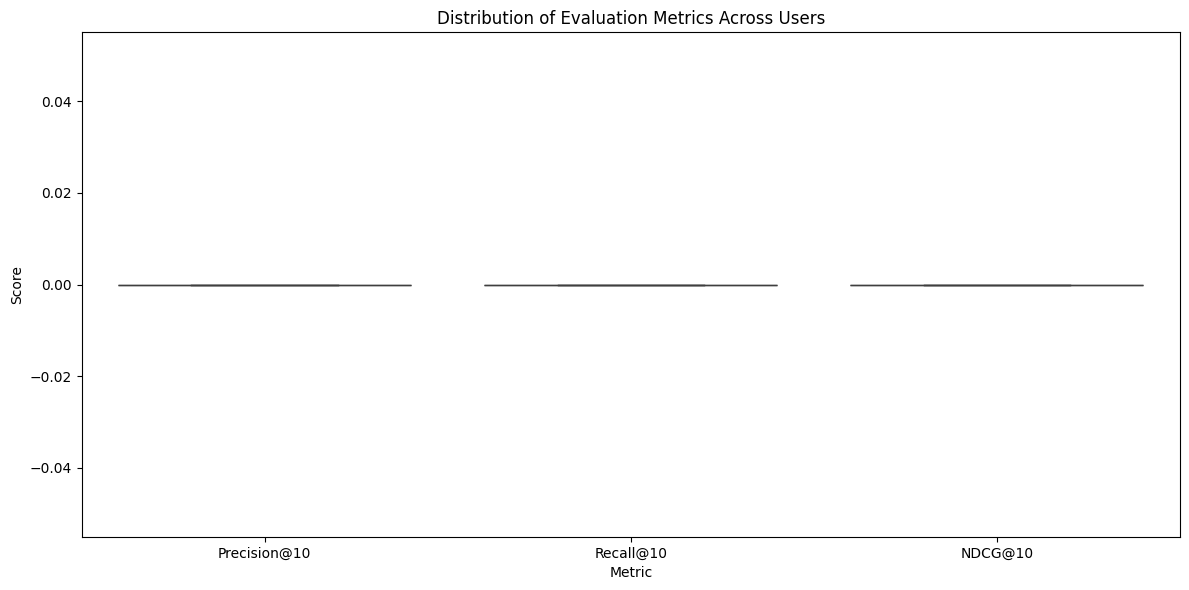

In [20]:
# Continue from where you left off

# Merge the ratings with the wine features
data = ratings_df_slim.merge(wines_df_slim, on='item')

# List of wine feature columns (exclude 'item' and any other non-feature columns if necessary)
wine_feature_columns = wines_df_slim.columns.tolist()
wine_feature_columns.remove('item')

# Initialize a list to store evaluation metrics
metrics_list = []

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from tqdm import tqdm

# Get the list of unique users
users = data['user'].unique()

# Iterate over each user
for user_id in tqdm(users, desc='Processing Users'):
    # Get the data for the current user
    user_data = data[data['user'] == user_id]
    
    # Skip users with insufficient data
    if len(user_data) < 5:
        continue  # Skip users with less than 5 ratings
    
    # Prepare features (X) and target variable (y)
    # X should contain only the wine features
    X = user_data[wine_feature_columns]
    y = user_data['rating_label']
    
    # Ensure that X contains only wine features
    # Optionally, print X.columns to verify
    # print("Features used for training:", X.columns.tolist())
    
    # Split into training and testing sets, stratified on 'rating_label'
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    except ValueError:
        # If stratification is not possible due to class imbalance, skip this user
        continue
    
    # Ensure all features are numerical
    X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Train the Decision Tree Classifier with max_depth=3
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, y_train)
    
    # Get the items not rated by the user
    user_rated_items = user_data['item'].unique()
    all_items = wines_df_slim['item'].unique()
    items_to_predict = np.setdiff1d(all_items, user_rated_items)
    
    # Get features for the items to predict
    items_to_predict_df = wines_df_slim[wines_df_slim['item'].isin(items_to_predict)]
    
    # Prepare features for prediction
    X_predict = items_to_predict_df[wine_feature_columns]
    
    # Ensure that the feature columns match those used in training
    missing_cols = set(X_train.columns) - set(X_predict.columns)
    for col in missing_cols:
        X_predict[col] = 0  # Add missing columns with default value 0
    X_predict = X_predict[X_train.columns]  # Reorder columns
    
    # Ensure all features are numerical
    X_predict = X_predict.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Predict the 'rating_label' for these items
    y_pred = clf.predict(X_predict)
    
    # Create a DataFrame with the predictions
    predictions_df = pd.DataFrame({
        'item': items_to_predict_df['item'],
        'predicted_rating_label': y_pred
    })
    
    # Map the predicted labels to scores for ranking (higher labels indicate higher preference)
    predictions_df['predicted_score'] = predictions_df['predicted_rating_label']
    
    # Get the top N recommendations
    top_n = 10
    recommendations = predictions_df.sort_values(by='predicted_score', ascending=False).head(top_n)
    
    # Prepare ground truth for evaluation
    # Get the items in the test set with 'rating_label' >= 1 (considered relevant)
    test_items = user_data.loc[y_test.index, 'item'].values
    relevant_items = user_data.loc[y_test.index][user_data['rating_label'] >= 1]['item'].values
    
    # Recommended items
    recommended_items = recommendations['item'].values
    
    # Compute evaluation metrics
    # Precision@N
    hits = [1 if item in relevant_items else 0 for item in recommended_items]
    num_hits = sum(hits)
    precision = num_hits / top_n if top_n > 0 else 0
    
    # Recall@N
    num_relevant_items = len(relevant_items)
    recall = num_hits / num_relevant_items if num_relevant_items > 0 else 0
    
    # NDCG@N
    relevance_scores = [1 if item in relevant_items else 0 for item in recommended_items]
    if sum(relevance_scores) > 0:
        ndcg = ndcg_score([relevance_scores], [relevance_scores], k=top_n)
    else:
        ndcg = 0.0
    
    # Store the metrics
    metrics_list.append({
        'user': user_id,
        'Precision@{}'.format(top_n): precision,
        'Recall@{}'.format(top_n): recall,
        'NDCG@{}'.format(top_n): ndcg
    })

# Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame(metrics_list)

# Compute the average metrics
average_metrics = metrics_df.mean(numeric_only=True)

# Display the average metrics
print("\nAverage Metrics Across All Users:")
for metric_name, value in average_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Optionally, visualize the distribution of metrics
metrics_melted = metrics_df.melt(
    id_vars='user',
    value_vars=['Precision@{}'.format(top_n), 'Recall@{}'.format(top_n), 'NDCG@{}'.format(top_n)],
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Metric', y='Score', data=metrics_melted)
plt.title('Distribution of Evaluation Metrics Across Users')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.tight_layout()
plt.show()
